In [1]:
import os
from PIL import Image as PILImage
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
dataset_path = '/data/gc-data-prepped-dlib'
session_path = '00003'
sample_path = '00000'

img_path_face = os.path.join(dataset_path, session_path, "appleFace", sample_path + ".jpg")
img_path_left_eye = os.path.join(dataset_path, session_path, "appleLeftEye", sample_path + ".jpg")
img_path_right_eye = os.path.join(dataset_path, session_path, "appleRightEye", sample_path + ".jpg")

pil_image_face = PILImage.open(img_path_face)
pil_image_left_eye = PILImage.open(img_path_left_eye)
pil_image_right_eye = PILImage.open(img_path_right_eye)

In [3]:
from ITrackerData import normalize_image_transform
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
color_space = 'YCbCr'

normalize_image = normalize_image_transform(image_size=IMAGE_SIZE, jitter=False, split='test')

def prepare_image_tensors(color_space, image_face, image_eye_left, image_eye_right, normalize_image, device):
    # Convert to the desired color space
    image_face = image_face.convert(color_space)
    image_eye_left = image_eye_left.convert(color_space)
    image_eye_right = image_eye_right.convert(color_space)

    # normalize the image, results in tensors
    tensor_face = normalize_image(image_face).to(device)
    tensor_eye_left = normalize_image(image_eye_left).to(device)
    tensor_eye_right = normalize_image(image_eye_right).to(device)

    # convert the 3 dimensional array into a 4 dimensional array, making it a batch size of 1
    tensor_face.unsqueeze_(0)
    tensor_eye_left.unsqueeze_(0)
    tensor_eye_right.unsqueeze_(0)

    return tensor_face, tensor_eye_left, tensor_eye_right

tensor_face, tensor_eye_left, tensor_eye_right = prepare_image_tensors(color_space,
                                                                       pil_image_face,
                                                                       pil_image_left_eye,
                                                                       pil_image_right_eye,
                                                                       normalize_image,
                                                                       device)

In [4]:
from ITrackerModel import ITrackerModel

def initialize_torch(path):
    model = ITrackerModel().to(device=device)
    saved = torch.load(path, map_location=device)
    model.load_state_dict(saved['state_dict'])
    model.eval()
    return model

model_path = 'checkpoints-ResNET18-YCbCr-unfrozen-dlib/best_checkpoint.pth.tar'
model = initialize_torch(model_path)

faceModel = model.faceModel.conv.model
leftEyeModel = model.eyeModel.model
rightEyeModel = model.eyeModel.model

model

ITrackerModel(
  (eyeModel): ItrackerImageModel(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

In [5]:
def compute_gradcam_images(tensor_image, model):
    configs = [
        dict(model_type='resnet', arch=model, layer_name='layer4'),
    ]

    for config in configs:
        config['arch'].to(device).eval()

    cams = [
        [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
        for config in configs
    ]
    
    images = []
    for gradcam, gradcam_pp in cams:
        mask, _ = gradcam(tensor_image)
        heatmap, result = visualize_cam(mask, tensor_image)

        mask_pp, _ = gradcam_pp(tensor_image)
        heatmap_pp, result_pp = visualize_cam(mask_pp, tensor_face)

        images.extend([tensor_image.cpu().squeeze_(0), heatmap, heatmap_pp, result, result_pp])
    
    return images

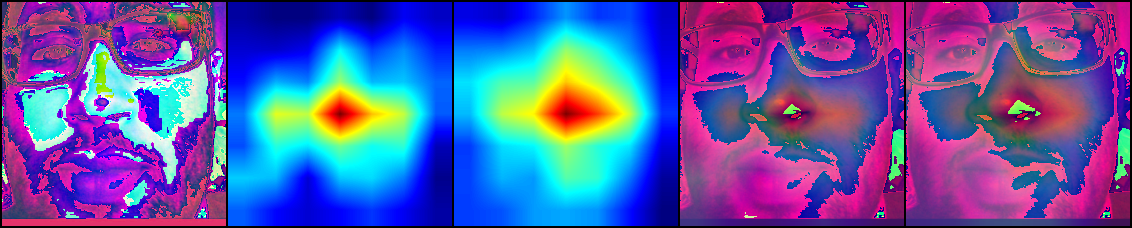

In [8]:
face_images = compute_gradcam_images(tensor_face, faceModel)
grid_face_images = make_grid(face_images, nrow=5)
transforms.ToPILImage()(grid_face_images)

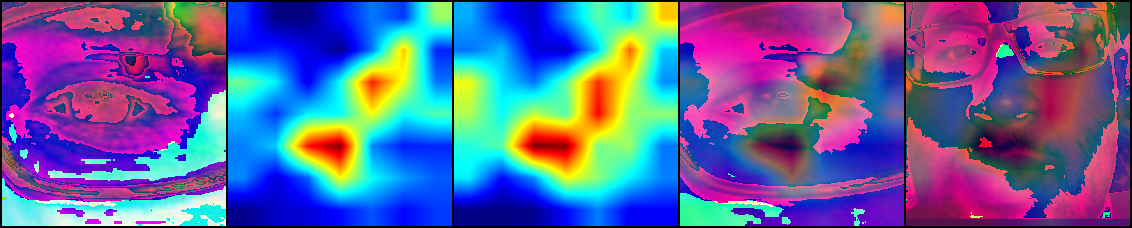

In [11]:
left_eye_images = compute_gradcam_images(tensor_eye_left, leftEyeModel)
grid_left_eye_images = make_grid(left_eye_images, nrow=5)
transforms.ToPILImage()(grid_left_eye_images)

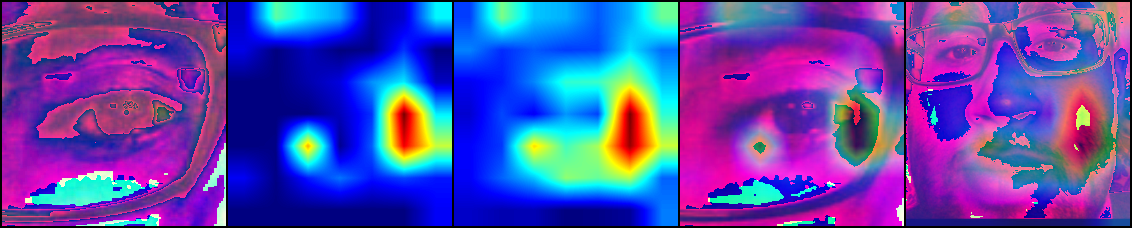

In [13]:
right_eye_images = compute_gradcam_images(tensor_eye_right, rightEyeModel)
grid_left_eye_images = make_grid(right_eye_images, nrow=5)
transforms.ToPILImage()(grid_left_eye_images)